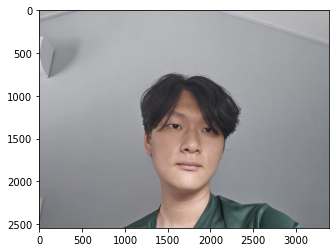

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# Load and display the image
my_image_path = 'aiffel/camera_sticker/images/face.jpg'
img_bgr = cv2.imread(my_image_path)

# Make a copy of the original image for processing and convert it to RGB format
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Display the RGB image using matplotlib
plt.imshow(img_rgb)
plt.show()

In [2]:
# Custom show function
def show():
    # Convert image color format from BGR to RGB for display
    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img_show_rgb)
    plt.axis('off')
    plt.show()

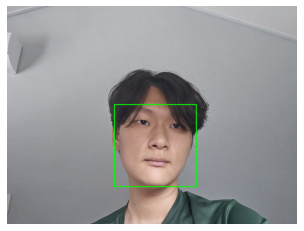

In [3]:
# Initialize the HOG-based face detector
detector_hog = dlib.get_frontal_face_detector()

# Detect faces in the image
dlib_rects = detector_hog(img_rgb, 1)

# Draw rectangles around detected faces
for rect in dlib_rects:
    left, top, right, bottom = rect.left(), rect.top(), rect.right(), rect.bottom()
    cv2.rectangle(img_show, (left, top), (right, bottom), (0, 255, 0), 10, lineType=cv2.LINE_AA)

# Display the image
show()

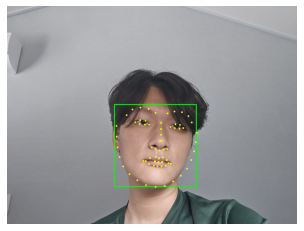

In [4]:
# Load the pre-trained model for face landmark prediction
model_path = 'aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# Detect landmarks and draw them on the image
list_landmarks = [
    [(point.x, point.y) for point in landmark_predictor(img_rgb, dlib_rect).parts()]
    for dlib_rect in dlib_rects
]

# Draw the landmarks on the image
for landmark in list_landmarks:
    for x, y in landmark:
        cv2.circle(img_show, (x, y), 10, (0, 255, 255), -1)

# Display the image
show()

Nose coordinates: (x, y) = (1793, 1628)
Overlay dimensions: (width, height) = (959, 959)


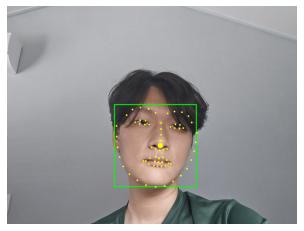

In [5]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # Extract the nose tip coordinates (index 30) from the landmarks.
    x = (landmark[30][0] + landmark[33][0]) // 2  # x-coordinate of the nose tip
    y = (landmark[30][1] + landmark[33][1]) // 2  # y-coordinate

    # Set width and height for an overlay, using the face rectangle's width.
    w = h = dlib_rect.width()

    # Debug output of the nose tip position and overlay dimensions.
    print(f'Nose coordinates: (x, y) = ({x}, {y})')
    print(f'Overlay dimensions: (width, height) = ({w}, {h})')
    
    # Display the image
    cv2.circle(img_show, (x, y), 30, (0, 255, 255), -1)
    show()

In [6]:
# Define the path to the sticker image
sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/whiskers.png'

# Load the sticker image using OpenCV
img_sticker = cv2.imread(sticker_path)

# Resize the sticker image to match the face width and height
img_sticker = cv2.resize(img_sticker, (w, h))

# Calculate the refined x and y coordinates for placing the sticker
refined_x = x - w // 2
refined_y = y - h // 2

# Print the refined coordinates to check if they are within the image bounds
print(f'Refined sticker position (x, y): ({refined_x}, {refined_y})')

# Crop the sticker to remove the portion that would be outside and adjust the xy-coordinate to start at 0.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

# After adjustments, print the new refined coordinates.
print(f'Newly refined sticker position (x, y): ({refined_x}, {refined_y})')

Refined sticker position (x, y): (1314, 1149)
Newly refined sticker position (x, y): (1314, 1149)


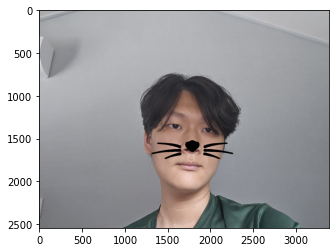

In [8]:
# Extracts a sub-area from the img_bgr image
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# Modifying the Original Image
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

# Displaying the Image
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

디버깅: 계속 투명으로 표시되야할 부분이 출력되어 np.where() documentation을 읽고 value_if_true와 value_if_false라는 파라미터가 잘못된 것을 발견하고 두 argument의 자리를 바꾸어 해결하였다.

회고: 다른 노드의 실험보다 비교적 어려웠지만, 도움을 받아 잘 해결하였다.